# Optimization Methods

jhbale11

[Coursera]Andrew Ng 's Deep Learning Lecture

https://github.com/suqi/deeplearning_andrewng

앤드류 응 교수님의 딥러닝 강의를 듣고 예제를 제 방식대로 연습한 결과입니다.

지금까지 경사하강법을 통해 Parameter를 업데이트하고 Cost를 최소화하는 과정을 연습했습니다. 이번 장에서는 Optimization 방법에 대해서 실습할 예정입니다. 이를 통해 학습을 빠르게 하고 비용 함수에 알맞은 값을 찾을 수 있습니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils_7 import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from utils_7 import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent

모든 훈련 샘플 $m$에 대한 기울기에 대한 기울기를 가지고 훈련을 진행하는 것을 경사 하강법, 또는 배치 경사 하강법이라고 합니다.

Gradient Descent Rule에 의해 $l = 1, ..., L :$
$W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{1} ... (1)$
$b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{2} ... (2)$

$L$은 Layer의 개수이며, $\alpha$는 Learning Rate를 의미합니다.

In [2]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    for i in parameters.keys():
        parameters[i] -= learning_rate * grads['d' + i]
    return parameters

    확률적 경사 하강법(Stochastic Gradient Descent; SGD)은 경사하강법의 한 종류입니다. 

    이것은 하나의 샘플에 대해 경사 하강법을 적용한 것으로서, 미니 배치의 크기가 1인 경사 하강법과 같습니다. 훈련셋의 크기가 클 경우 SGD는 빠르지만 최저점을 향해 진동할 것이며, SGD는 샘플을 하나씩 이용하기 때문에 백터 계산의 장점을 살리지 못합니다.

    반면 미니배치 경사 하강법(Mini-Batch Gradeint Descent)은 배치 경사 하강법과 확률적 경사 하강법의 중간 방법으로서, 중간 정도 크기의 샘플에 대해 경사 하강법을 적용합니다. 일반적으로 미니배치 경사 하강법은, 특히 훈련셋의 크기가 클 경우 배치 경사 하강법이나 SGD보다 성능이 뛰어납니다.


## 2 - Mini-Batch Gradient descent

    미니배치 경사하강법은 
    1. 샘플 뒤섞기(Shuffle) 
    2. 샘플 나누기(Partition)의 순서로 구현합니다. 
    
    훈련셋의 전체 샘플 개수가 미니배치의 크기로 나누어떨어지지 않을 경우, 마지막 미니배치의 크기는 다른 미니배치보다 작아야 합니다.

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[1]      
    mini_batches = []
    
    # 1단계: 뒤섞기
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]
    
    # 2단계: 나누기
    num_complete_minibatches = m // mini_batch_size
    for i in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, i*mini_batch_size:(i+1)*mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))
    
    return mini_batches

## 3 - Momentum

모멘텀을 이용하면 훈련 과정에서 생기는 진폭을 줄일 수 있습니다. 그레디언트의 지수 이동 평균 값을 이용해서 과거 그레디언트를 반영하는 값을 파라미터 업데이트에 사용하는 것입니다. 이때 과거 그레디언트 값을 저장하는 $v$는 언덕을 내려가는 "속도"로 이해할 수 있을 것입니다.


$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}$$


In [4]:
def initialize_velocity(parameters):
    v = {}
    for i in parameters.keys():
        v['d' + i] = np.zeros(parameters[i].shape)
    return v

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    
    for i in parameters.keys():
        v['d'+i] = beta*v['d'+i] + (1-beta)*grads['d'+i]
        parameters[i] -= learning_rate*v['d'+i]
    return parameters, v

- 속도 v는 0으로 초기화해주었습니다. 그러므로 처음에는 훈련의 보폭이 크지 않습니다. (편향을 보정해줄 수도 있습니다)
- 만약 $\beta = 0$으로 놓으면, 이는 표준적인 경사 하강법과 같습니다. 

- $\beta$ 값이 클수록 과거의 그레디언트를 더 많이 반영합니다. 
- 일반적으로 $\beta$ 값은 0.8~0.999의 값을 선택합니다. 따라서 실습에서 사용한 $\beta = 0.9$는 합리적인 초기값이 될 것입니다.

## 4 - Adam

아담은 RMSProp과 Momentum을 합쳐놓은 것입니다.

$$\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}$$

- 업데이트가 진행될수록 편향을 보정할 필요가 적어지는데, 이것이 t에 의해 반영됩니다.
- $\varepsilon$는 분모가 0이 되는 걸 방지하기 위해 도입된 작은 값입니다.


In [5]:
def initialize_adam(parameters) :
    
    v = {}
    s = {}
    for i in parameters.keys():
        v['d'+i] = np.zeros_like(parameters[i])
        s['d'+i] = np.zeros_like(parameters[i])
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    v_corrected = {}
    s_corrected = {}
    for i in parameters.keys():
        
        v['d'+i] = beta1*v['d'+i] + (1-beta1)*grads['d'+i]
        v_corrected['d'+i] = v['d'+i] / (1-beta1**t)
        
        s['d'+i] = beta2*s['d'+i] + (1-beta2)*(grads['d'+i]**2)
        s_corrected['d'+i] = s['d'+i] / (1-beta2**t)
        
        parameters[i] -= learning_rate * v_corrected['d'+i] / (np.sqrt(s_corrected['d'+i])+epsilon)
    
    return parameters, v, s

이제 최적화 기법들을 시험해보겠습니다.

## 5 - Model with different optimization algorithms

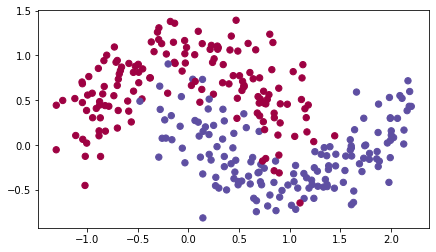

In [6]:
train_X, train_Y = load_dataset()

3층 신경망에 대해 다음을 시험해보겠습니다.

- Mini-batch **Gradient Descent**
- Mini-batch **Momentum**
- Mini-batch **Adam**

In [7]:
# 비교에 사용할 3층 신경망 모델
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        minibatches = random_mini_batches(X, Y, mini_batch_size)

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 10 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 5.1 - Mini-batch Gradient descent

Cost after epoch 0: 0.791419
Cost after epoch 1000: 0.376955
Cost after epoch 2000: 0.291096
Cost after epoch 3000: 0.304614
Cost after epoch 4000: 0.530348
Cost after epoch 5000: 0.234717
Cost after epoch 6000: 0.217750
Cost after epoch 7000: 0.307228
Cost after epoch 8000: 0.266493
Cost after epoch 9000: 0.300218


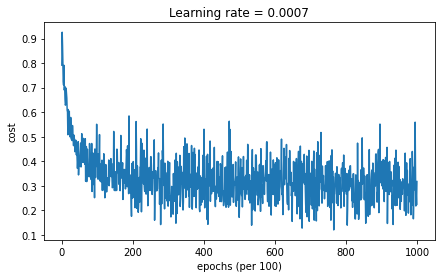

Accuracy: 0.87


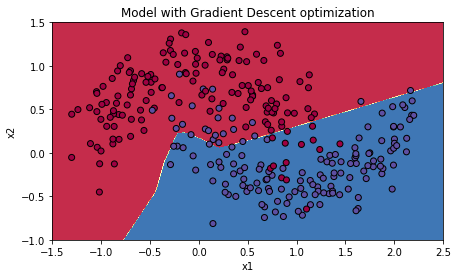

In [8]:
# train 3-layer model
layers_dims = [train_X.shape[0], 20, 12, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.2 - Mini-batch gradient descent with momentum

Cost after epoch 0: 0.792892
Cost after epoch 1000: 0.377037
Cost after epoch 2000: 0.291119
Cost after epoch 3000: 0.304642
Cost after epoch 4000: 0.530356
Cost after epoch 5000: 0.234731
Cost after epoch 6000: 0.217754
Cost after epoch 7000: 0.307238
Cost after epoch 8000: 0.266499
Cost after epoch 9000: 0.300099


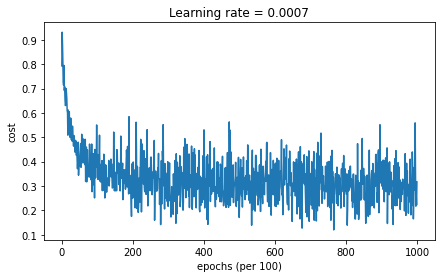

Accuracy: 0.87


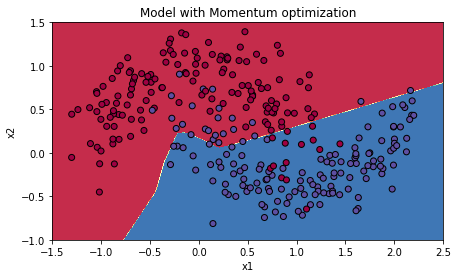

In [9]:
# train 3-layer model
layers_dims = [train_X.shape[0], 20, 12, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

지금의 예시가 비교적 단순하기 때문에 모멘텀을 사용한 효과가 작습니다. 하지만 복잡한 문제에서는 차이를 볼 수 있을 것입니다!

### 5.3 - Mini-batch with Adam mode

Cost after epoch 0: 0.777183
Cost after epoch 1000: 0.074071
Cost after epoch 2000: 0.071786
Cost after epoch 3000: 0.141904
Cost after epoch 4000: 0.118044


/home/junghwan/junghwan/deeplearning_andrewng-master/utils_7.py:93: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/junghwan/junghwan/deeplearning_andrewng-master/utils_7.py:93: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after epoch 5000: 0.045960
Cost after epoch 6000: 0.097558
Cost after epoch 7000: 0.079215
Cost after epoch 8000: nan
Cost after epoch 9000: 0.104765


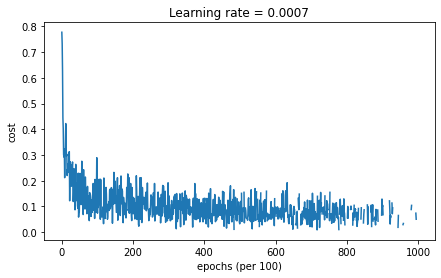

Accuracy: 0.9766666666666667


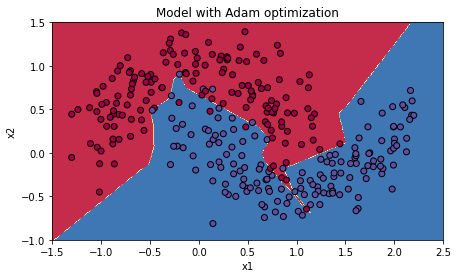

In [10]:
# train 3-layer model
layers_dims = [train_X.shape[0], 20, 12, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### 5.4 - Summary

아담은 미니배치 경사 하강법이나 모멘텀보다 분명이 성능이 좋게 나왔습니다. 만약 학습을 오래 시키면 다른 방법들도 좋은 결과를 낼 것입니다. 하지만 아담은 성능 좋음은 물론 훨씬 빠르게 수렴하는 것을 볼 수 있습니다.

아담의 장점은 다음과 같습니다.

- 상대적으로 요구되는 메모리가 작다는 점. (경사 하강법이나 모멘텀보다는 많이 들긴 하지만)
- 하이퍼 파라미터 튜닝을 거의 하지 않고도 잘 작동한다는 점. ($\alpha$ 제외)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf